Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [49]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    
    ## flatten the layer1_weight to a 2D matrix [patch_size * patch_size * num_channels, depth]
    ## Extract image patches from the input tensor form a virtual tensor of shape 
    ## [batch, out_height, out_width, filter_height * filter_width * in_channel]
    ## right-mutiples the filter matrix and image patch vector. 
    ## conv with shape [batch, depth]
    
    print('shape of conv:{0} '.format(conv.get_shape()))
    
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

shape of conv:(16, 14, 14, 16) 
shape of conv:(10000, 14, 14, 16) 
shape of conv:(10000, 14, 14, 16) 


In [80]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.959296
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.036950
Minibatch accuracy: 62.5%
Validation accuracy: 49.4%
Minibatch loss at step 100: 0.682357
Minibatch accuracy: 68.8%
Validation accuracy: 63.1%
Minibatch loss at step 150: 1.070658
Minibatch accuracy: 68.8%
Validation accuracy: 70.2%
Minibatch loss at step 200: 1.200238
Minibatch accuracy: 75.0%
Validation accuracy: 73.6%
Minibatch loss at step 250: 0.612329
Minibatch accuracy: 81.2%
Validation accuracy: 74.9%
Minibatch loss at step 300: 0.893899
Minibatch accuracy: 75.0%
Validation accuracy: 78.9%
Minibatch loss at step 350: 0.331759
Minibatch accuracy: 93.8%
Validation accuracy: 78.6%
Minibatch loss at step 400: 0.461813
Minibatch accuracy: 93.8%
Validation accuracy: 79.4%
Minibatch loss at step 450: 0.484913
Minibatch accuracy: 87.5%
Validation accuracy: 78.5%
Minibatch loss at step 500: 0.394682
Minibatch accuracy: 81.2%
Validation accuracy: 79.7%
M

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [28]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    #conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    conv = tf.nn.avg_pool(data, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    #conv = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

num_steps = 3001
batch_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
            b_accuracy = accuracy(predictions, batch_labels)
            batch_accuracy.append(b_accuracy)
            v_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            validation_accuracy.append(v_accuracy)
            
            if(step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % b_accuracy)
                print("Validation accuracy: %.1f%%" % v_accuracy)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.372473
Minibatch accuracy: 0.0%
Validation accuracy: 12.7%
Minibatch loss at step 500: 0.597660
Minibatch accuracy: 81.2%
Validation accuracy: 80.4%
Minibatch loss at step 1000: 1.054735
Minibatch accuracy: 62.5%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.785615
Minibatch accuracy: 75.0%
Validation accuracy: 84.2%
Minibatch loss at step 2000: 0.925847
Minibatch accuracy: 81.2%
Validation accuracy: 84.7%
Minibatch loss at step 2500: 0.295379
Minibatch accuracy: 87.5%
Validation accuracy: 85.1%
Minibatch loss at step 3000: 0.877261
Minibatch accuracy: 68.8%
Validation accuracy: 85.8%
Test accuracy: 91.8%


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

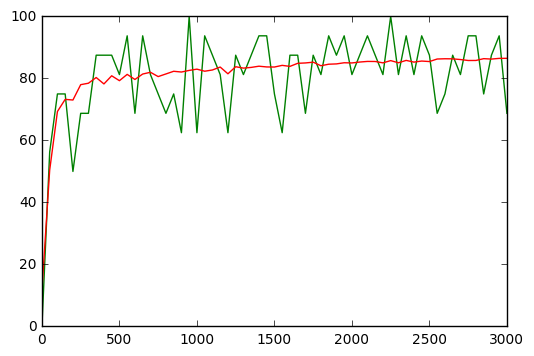

In [14]:
'''Conv2d => hidden => Conv2d => hidden '''
'''
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

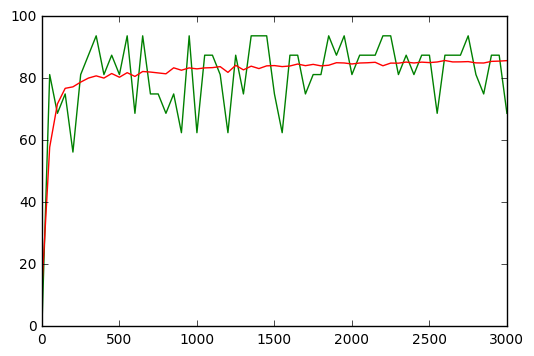

In [29]:
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [78]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
deeper = 32

def model(data):
    #conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    #conv1 = tf.nn.avg_pool(data, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    ## parameter of conv2d: @param 1st: input, with shape [batch, in_height, in_width, in_channel], 
    ## batch, height, width, channel, 
    ## 2nd @param filter: [filter_height, filter_width, in_channel, out_channel]
    ## Flatten the filter to a 2-D matrix with shape [filter_height * filter_width * in_channel, output_channel]
    ## Extract image patches from the input tensor to form a virtual tensor of shape 
    ## [batch, out_height, out_width, filter_height * filter_width * in_channel]
    

    #conv = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    #conv = tf.nn.dropout(conv, keep_prob=0.5, seed=0.0)
    shape = pool4.get_shape().as_list()
    reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    return tf.matmul(hidden, layer4_weights) + layer4_biases

graph = tf.Graph()
with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal([size3 * size3 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
      
    # Model.
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
      # Optimizer.
    global_step = tf.Variable(0, trainable=False)
    start_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 30001, 0.9, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

num_steps = 20001
batch_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
            b_accuracy = accuracy(predictions, batch_labels)
            batch_accuracy.append(b_accuracy)
            v_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            validation_accuracy.append(v_accuracy)
            
            if(step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % b_accuracy)
                print("Validation accuracy: %.1f%%" % v_accuracy)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.985445
Minibatch accuracy: 12.5%
Validation accuracy: 7.4%
Minibatch loss at step 500: 0.410304
Minibatch accuracy: 87.5%
Validation accuracy: 80.4%
Minibatch loss at step 1000: 0.717729
Minibatch accuracy: 81.2%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.636847
Minibatch accuracy: 75.0%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 0.901346
Minibatch accuracy: 75.0%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 0.393725
Minibatch accuracy: 87.5%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 0.999301
Minibatch accuracy: 68.8%
Validation accuracy: 86.9%
Minibatch loss at step 3500: 0.924676
Minibatch accuracy: 75.0%
Validation accuracy: 87.2%
Minibatch loss at step 4000: 0.407523
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%
Minibatch loss at step 4500: 0.163172
Minibatch accuracy: 93.8%
Validation accuracy: 87.3%
Minibatch loss at step 5000: 0.457847
Minibatch accuracy: 87.5%
Validation accuracy

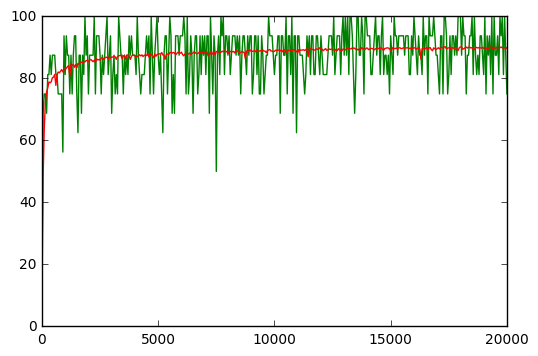

In [79]:
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')